In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import json
import nltk
import wordcloud
import spacy
import random

In [2]:
df = pd.read_json("../../ITA_WS_2020/datasets/whats-cooking/train.json")


In [8]:
print(f"Number of recipes before dropna: {len(df)}")
df.dropna(inplace=True, subset=["ingredients"])
print(f"Number of recipes after dropna: {len(df)}")

Number of recipes before dropna: 39774
Number of recipes after dropna: 39774


## Ingredients

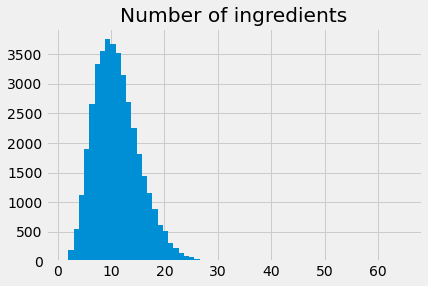

Median number of ingredients: 10.0
Std. deviation of number of ingredients: 4.43


In [9]:
def count_ingredients(ingredients):
    if isinstance(ingredients, list):
        return len(ingredients)
    else:
        return 0

df['n_ingredients'] = df.ingredients.apply(count_ingredients)

#plot distribution
plt.title("Number of ingredients")
plt.hist(df.n_ingredients.tolist(), bins=max(df.n_ingredients.tolist()))
plt.show()

print(f"Median number of ingredients: {df.n_ingredients.median()}")
print(f"Std. deviation of number of ingredients: {df.n_ingredients.std():.2f}")

The median number of ingredients is 10, which seems plausible. However, the majority has 4-15 ingredients.


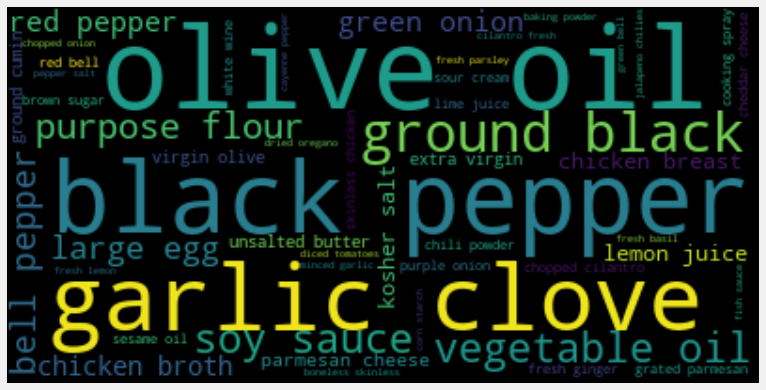

In [13]:
total_ingredients = nltk.flatten(df.ingredients.tolist())
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(total_ingredients))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

As one can see, olive oil is the most prominent ingredient. There seems to be no extra stop words, that need extra removal.



### TOP 15 Ingredients network

We want to evaluate the cooccurances of ingredients in recipes to gain insight into the structure of recipes.

In [14]:
from collections import Counter
import tqdm
import networkx as nx
counter = Counter()
#### Count the words in the scripts and print out the most common 20, remove any single character tokens and stem
counter.update(total_ingredients)
ingredients_of_interest = counter.most_common(15)
ing_dict = {ingredients_of_interest[i][0]: i for i in range(0, len(ingredients_of_interest))}
print(ing_dict)

{'salt': 0, 'onions': 1, 'olive oil': 2, 'water': 3, 'garlic': 4, 'sugar': 5, 'garlic cloves': 6, 'butter': 7, 'ground black pepper': 8, 'all-purpose flour': 9, 'pepper': 10, 'vegetable oil': 11, 'eggs': 12, 'soy sauce': 13, 'kosher salt': 14}


In [15]:
def to_matrix(ingredients_per_recipe, ingredients):
    matrix = np.zeros((len(ingredients),len(ingredients)))
    for ing_list in ingredients_per_recipe:
        for ing1 in ing_list:
            for ing2 in ing_list:
                if True:
                    try:
                        matrix[ingredients[ing1]][ingredients[ing2]] += 1
                    except:
                        pass
    return matrix
matrix = to_matrix(df.ingredients.tolist(),ing_dict)


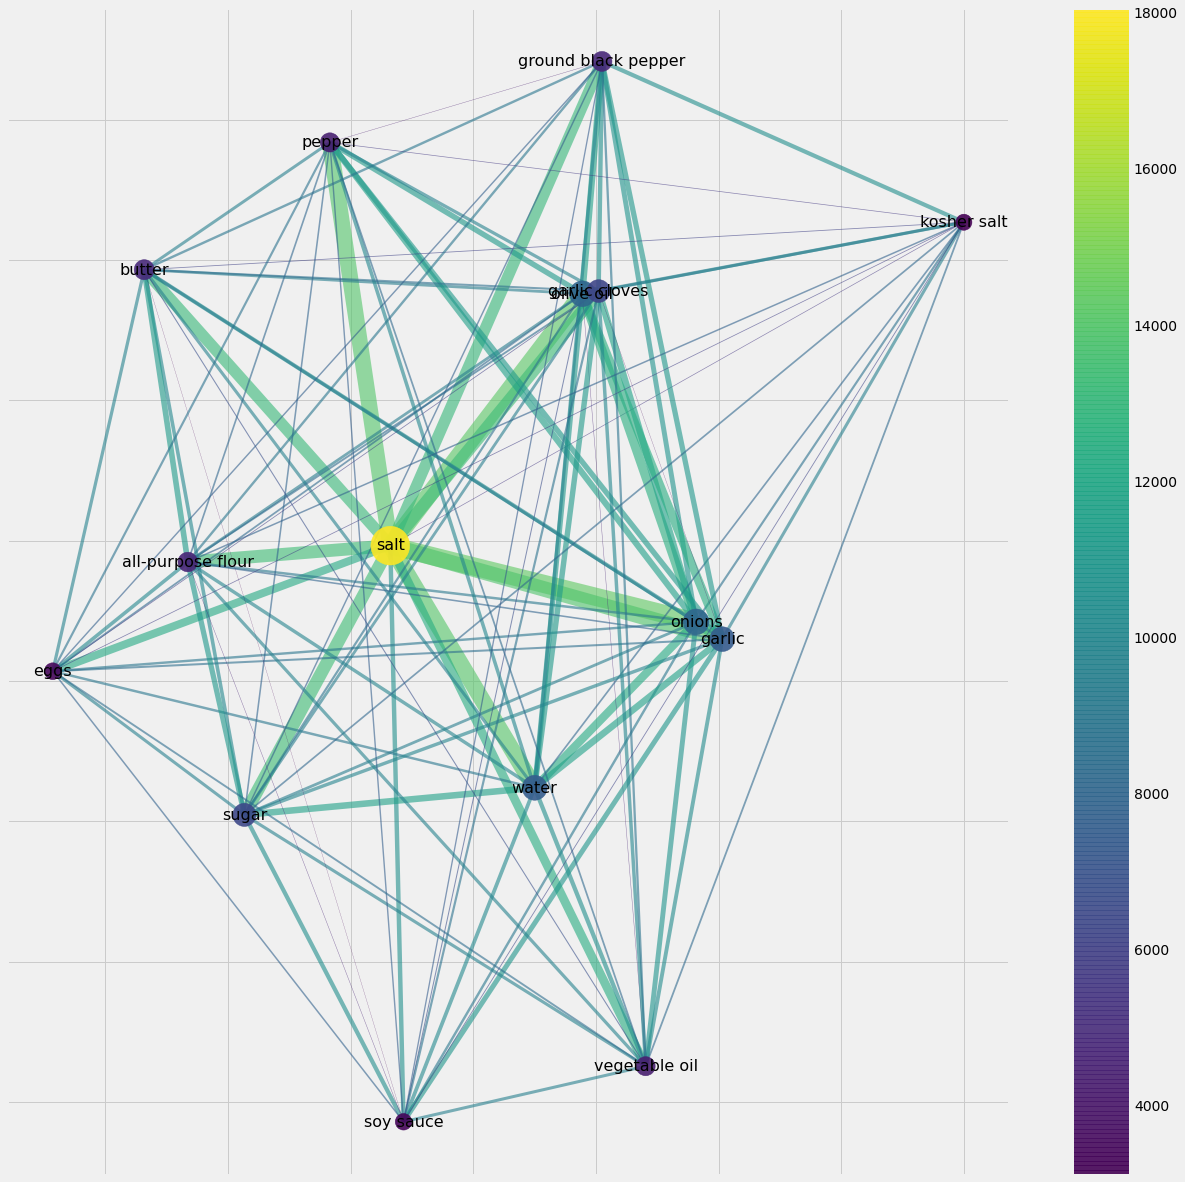

In [16]:

# inspired by https://gist.github.com/AruniRC/2c53fe7680eeb578593ec816bbfb1653
g = nx.from_numpy_matrix(matrix)
adj_mat_normed = matrix

affinities  = {}
for edge in g.edges():
    affinities[edge] = adj_mat_normed[edge[0], edge[1]]
nx.set_edge_attributes(g, affinities, 'my_weight')
pos = nx.spring_layout(g, weight = 'my_weight')
#pos = nx.circular_layout(g)
maxW = 15/adj_mat_normed[0][0]
edge_wts = [ 5*maxW*(adj_mat_normed[edge[0], edge[1]]) for edge in g.edges()]

node_szs = [100*maxW*matrix[node][node] for node in g.nodes()]  # proportional to "saliency"
# node_szs = [5.0 * adj_mat[node].sum() for node in g.nodes()]
n_colors = [matrix[node][node] for node in g.nodes()]  # node color also proportional to saliency
n_edges = [np.log(matrix[edge[0]][edge[1]]) for edge in g.edges()] 
plt.figure(figsize=(20,20))

sc = nx.draw_networkx_nodes(G=g, pos = pos, nodelist = g.nodes(), alpha=0.9, 
                        node_size = node_szs, node_color=n_colors, cmap='viridis')
# node_labels=
nx.draw_networkx_edges(g, pos = pos, edge_color=n_edges, alpha=0.6,  width=edge_wts)

nx.draw_networkx_labels(g,pos,{i:ingredients_of_interest[i][0] for i in range(len(ingredients_of_interest))},font_size=16)
#sc.set_norm(mcolors.LogNorm()) # log-scale colormap for better visualization and contrast
plt.colorbar(sc)
plt.show()

The plot shows that some ingredients co-occur quite often: salt and pepper, or sugar and salt for example. There are variants of salts: non kosher and kosher, and they do occur in the same recipes not often and partion the graph.

Idea compare different cusines